<a href="https://colab.research.google.com/github/joankl/2Sphere-pixels/blob/main/2Sphere_pixels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sphere Surface Pixel **Division**

In [ ]:
import uproot

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
import seaborn as sn
from tqdm import tqdm

import numpy as np
from numpy import array, where, shape, reshape, pi, cos, sin, sqrt, linspace
np.set_printoptions(threshold=1000)

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 1 Uploading info.

In [ ]:
file = uproot.open('/content/gdrive/MyDrive/Colab Notebooks/py_out1.root')

## 1.1) Event Info.

In [ ]:
data1 = file['T;7']
data1.keys()

['evtid',
 'mc_position',
 'mc_momentum',
 'position',
 'momentum',
 'hit_pmtid',
 'hit_pmttime',
 'hit_residual',
 'hit_type']

In [ ]:
evtid = np.array(data1['evtid'])
mc_position = np.array(data1['mc_position'])
position = np.array(data1['position'])
hit_pmtid = np.array(data1['hit_pmtid'])
hit_pmttime = np.array(data1['hit_pmttime'])
hit_residual = np.array(data1['hit_residual'])
hit_type = np.array(data1['hit_type'])

## 1.2) PMT Info.

In [ ]:
pmt_info = file['pmt;1']
pmt_info.keys()

['pmt_id', 'pmt_pos_xyz', 'pmt_pos_sph', 'pmt_type']

In [ ]:
pmt_id = array(pmt_info['pmt_id'])
pmt_pos_xyz = array(pmt_info['pmt_pos_xyz'])
pmt_pos_sph = array(pmt_info['pmt_pos_sph'])
pmt_type = array(pmt_info['pmt_type'])

In [ ]:
#Lets separate their coordinates
#xyz:

prefix_xyz = 'type_'
suffix_xyz = '_xyz'

type_var = np.unique(pmt_type)

for i in type_var:
    condition = (pmt_type == i)
    locals()[prefix_xyz + str(i) + suffix_xyz] = []

    for j in (where(condition)[0]):
        locals()[prefix_xyz + str(i) + suffix_xyz].append(pmt_pos_xyz[j])
    locals()[prefix_xyz + str(i) + suffix_xyz] = np.array(locals()[prefix_xyz + str(i) + suffix_xyz])

#spherical:

prefix_sph = 'type_'
suffix_sph = '_sph'

type_var = np.unique(pmt_type)

for i in type_var:
    condition = (pmt_type == i)
    locals()[prefix_sph + str(i) + suffix_sph] = []

    for j in (where(condition)[0]):
        locals()[prefix_sph + str(i) + suffix_sph].append(pmt_pos_sph[j])
    locals()[prefix_sph + str(i) + suffix_sph] = np.array(locals()[prefix_sph + str(i) + suffix_sph])

In [ ]:
type_1_xyz

array([[ 5467.54,    63.44, -6406.27],
       [ 5615.16,   266.8 , -6251.09],
       [ 5762.73,   469.91, -6095.92],
       ...,
       [ 6275.45, -5446.47,  1161.1 ],
       [ 5941.19, -5754.32,  1395.85],
       [ 6078.68, -5666.4 ,  1149.76]])

In [ ]:
type_1_sph

array([[ 2.43505602e+00,  1.16025037e-02,  8.42248856e+03],
       [ 2.40917419e+00,  4.74785216e-02,  8.40698104e+03],
       [ 2.38262954e+00,  8.13629337e-02,  8.40179226e+03],
       ...,
       [ 1.43196114e+00, -7.14795215e-01,  8.39008113e+03],
       [ 1.40360795e+00, -7.69421596e-01,  8.38798751e+03],
       [ 1.43331289e+00, -7.50310212e-01,  8.38930197e+03]])

### 1.2.1) PMT postion vs. Vesel - 3D plot visualización

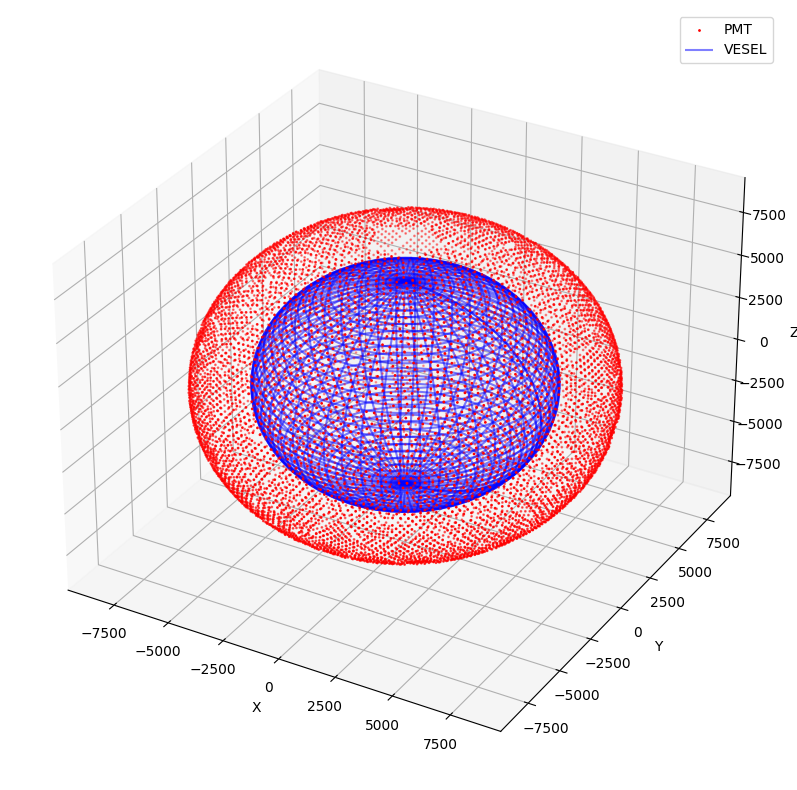

In [ ]:
#Add points - PMT coords!

type_x = type_1_xyz[:,0]
type_y = type_1_xyz[:,1]
type_z = type_1_xyz[:,2]

fig = plt.figure(figsize = (10,10))

# Parámetros para crear la esfera
r = 6000  # Radio de la esfera
phi = np.linspace(0, np.pi, 100)
theta = np.linspace(0, 2 * np.pi, 100)
phi, theta = np.meshgrid(phi, theta)

# Coordenadas cartesianas para la esfera
x = r * np.sin(phi) * np.cos(theta)
y = r * np.sin(phi) * np.sin(theta)
z = r * np.cos(phi)

# Configuración de la figura 3D
ax = fig.add_subplot(projection='3d')

# Graficar la esfera vs. coordenadas de PMTs
ax.scatter(type_x, type_y, type_z, c = 'r', s = 1, label = 'PMT')
ax.plot_wireframe(x, y, z, alpha=0.5, color = 'blue',label = 'VESEL')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

# Mostrar la gráfica
plt.show()


# 2) Divide the 2S en pixeles

### IMPORTANTE OBSERVAR
- Cenital minimo de pmt spherical type 1

In [ ]:
zenit_minimal = np.min(type_1_sph[:,0])
zenit_minimal

0.1572726015543194

- radio medio de PMTs type 1

Tiene sentido extraer un radio médio? Observa solo la distribución radial de PMTs... no parece ser accidental:

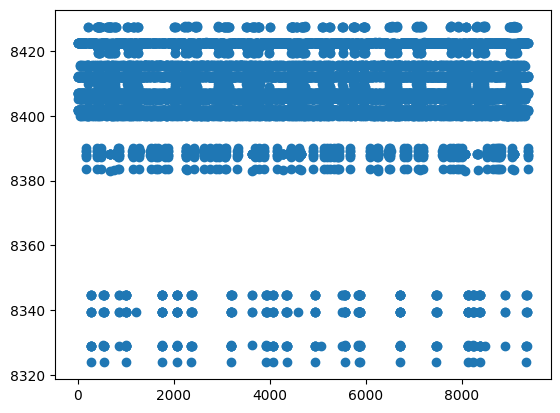

In [ ]:
plt.plot(type_1_sph[:,2], 'o')

In [ ]:
r_med = np.average(type_1_sph[:,2])
r_med

8406.882920133025

### 2.1) Modeling section division vs PMT position

In [ ]:
#Angle Division
zenit_div = 20
azimut_div = 40
r = r_med  # Radio de la esfera

#Angle generation
zenit = np.linspace(zenit_minimal, pi - zenit_minimal, zenit_div+1)
azimut = np.linspace(-pi, pi, azimut_div+1)
zenit_grid, azimut_grid = np.meshgrid(zenit, azimut)

#GRAFICO

x = r * np.sin(zenit_grid) * np.cos(azimut_grid)
y = r * np.sin(zenit_grid) * np.sin(azimut_grid)
z = r * np.cos(zenit_grid)

fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(projection='3d')
ax.plot_wireframe(x, y, z, alpha=1, color = 'k',label = 'Division')
ax.scatter(type_x, type_y, type_z, c = 'r', s = 2, label = 'PMT')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

ax.axes.set_xlim3d(left=-9000, right=9000)
ax.axes.set_ylim3d(bottom=-9000, top=9000)
ax.axes.set_zlim3d(bottom=-9000, top=9000)

plt.show()

In [ ]:
#PMT counting per unit of solid angels (d_zenit x d_azimut)r^2
zenit_div = 20
azimut_div = 40

#Angle generation
zenit = np.linspace(zenit_minimal, pi - zenit_minimal, zenit_div+1)
azimut = np.linspace(-pi, pi, azimut_div+1)

dN_pmt = np.array([], dtype = np.int64)                                           #acumulated amout of PMTs in an angular division
d_sigma_pmt = np.array([])                                                        # Density of dN_pmt per unit of area (1/(mm^-3))

size = shape(type_1_sph)[0]

for i in range(zenit_div):
    d_zenit = zenit[i:i+2]                                                      #2x1 array

    for j in range(azimut_div):
        pmt_count = 0                                                             # Nº of pmt in angular region
        d_azimut = azimut[j:j+2]                                                    #2x1 array
        #A = (d_azimut[1] - d_azimut[0])*(d_zenit[1]-d_zenit[0])*(r_med**2)        # Area of angular region
        #print(A)

        for k in range(size):
            zenit_pmt = type_1_sph[k][0]
            azimut_pmt = type_1_sph[k][1]
            #print(d_zenit[0])

            if (zenit_pmt > d_zenit[0] and zenit_pmt <= d_zenit[1]) and (azimut_pmt >= d_azimut[0] and azimut_pmt <= d_azimut[1]):
                pmt_count += 1

        #PMT number in this region
        dN_pmt = np.append(dN_pmt, pmt_count)

        #PMT density in this region,
        #d_sigma_pmt = np.append(d_sigma_pmt, (pre_count)/(A))


In [ ]:
dN_pmt

In [ ]:
len(dN_pmt)

800

# 3) Dividir estructura de soporte de PMT

### 3.1) Firts test: Division in 4 parts

$\theta  -> \theta/2$ y $\phi -> \phi/4$

In [ ]:
#1st sector observation

first_sector_i = []
first_sector_xyz = []


size = shape(type_1_sph)[0]

for i in range(size):

    #cos_azimut = cos(type_1_sph[i][0])
    #cos_polar = cos(type_1_sph[i][1])
    azimut = type_1_sph[i][0]
    polar = type_1_sph[i][1]

    #choose the sector
    if (azimut >= 0 and azimut <= pi/2) and (polar >= -pi and polar <= 0):
        first_sector_xyz.append(type_1_xyz[i])

first_sector_xyz = np.array(first_sector_xyz)

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.grid()

x = first_sector_xyz[:,0]
y = first_sector_xyz[:,1]
z = first_sector_xyz[:,2]

ax.scatter(x, y, z, c = 'r', s = 5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#ax.legend()

ax.axes.set_xlim3d(left=-8000, right=8000)
ax.axes.set_ylim3d(bottom=-8000, top=8000)
ax.axes.set_zlim3d(bottom=-8000, top=8000)

(-8000.0, 8000.0)

In [ ]:
type_1_sph

array([[ 2.43505602e+00,  1.16025037e-02,  8.42248856e+03],
       [ 2.40917419e+00,  4.74785216e-02,  8.40698104e+03],
       [ 2.38262954e+00,  8.13629337e-02,  8.40179226e+03],
       ...,
       [ 1.43196114e+00, -7.14795215e-01,  8.39008113e+03],
       [ 1.40360795e+00, -7.69421596e-01,  8.38798751e+03],
       [ 1.43331289e+00, -7.50310212e-01,  8.38930197e+03]])

## 3.2) Selection of PMT given angular regions

(-8000.0, 8000.0)

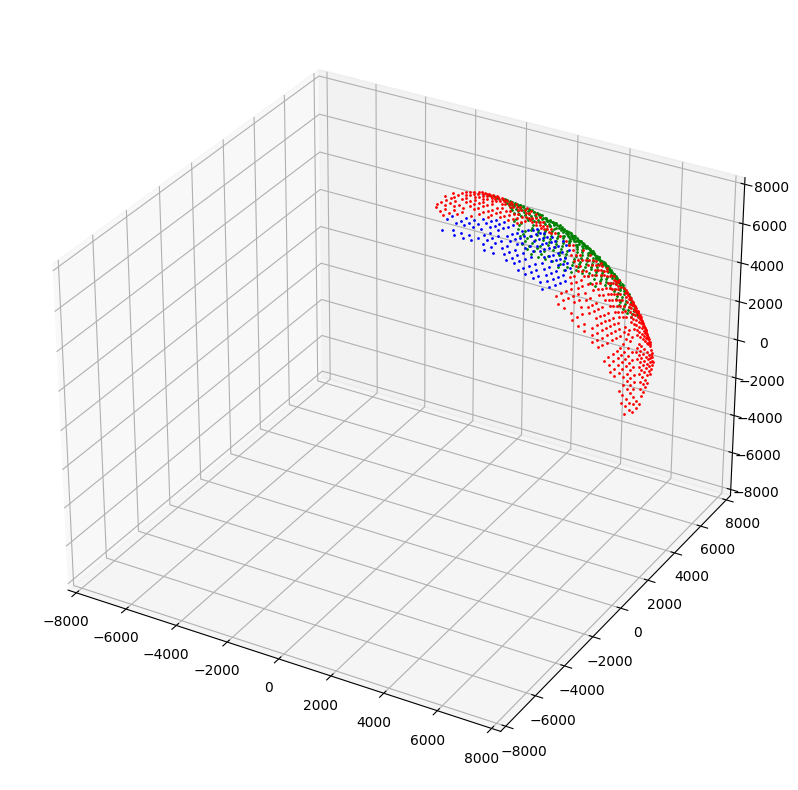

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.grid()

#Lower and upper angle limits
azimut_lim = [0, pi/2]
zenit_lim = [0, pi/2]

#Angle divisions
zenit_div = 2
azimut_div = 2

zenit = np.linspace(zenit_lim[0] , zenit_lim[1] - zenit_minimal, zenit_div+1)
azimut = np.linspace(azimut_lim[0], azimut_lim[1], azimut_div+1)

size = shape(type_1_sph)[0]
colors = ['b', 'r', 'g']

# Construct pixels in azimuth angel keeping zenith const.
for i in range(zenit_div):
    d_zenit = zenit[i:i+2]                                                         #2x1 array

    for j in range(azimut_div):
        pmt_count = 0                                                              # Nº of pmt in angular region
        d_azimut = azimut[j:j+2]                                                   #2x1 array

        #extract PMT coordinates and see if there are inside divisions
        for k in range(size):
            zenit_pmt = type_1_sph[k][0]
            azimut_pmt = type_1_sph[k][1]
            sector_xyz = []

            if (zenit_pmt > d_zenit[0] and zenit_pmt <= d_zenit[1]) and (
                azimut_pmt >= d_azimut[0] and azimut_pmt <= d_azimut[1]):

                sector_xyz.append(type_1_xyz[k])
                array_sector_xyz = np.array(sector_xyz)

                x = array_sector_xyz[:,0]
                y = array_sector_xyz[:,1]
                z = array_sector_xyz[:,2]
                #color_counter += 1
                #print(color_counter)

                ax.scatter(x, y, z, c = colors[i+j], s = 1)
                #ax.scatter(x, y, z, c = 'r', s = 1)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# #ax.legend()

ax.axes.set_xlim3d(left=-8000, right=8000)
ax.axes.set_ylim3d(bottom=-8000, top=8000)
ax.axes.set_zlim3d(bottom=-8000, top=8000)